In [2]:
# ---
# date: 2024-05-29
# excerpt: how to simulate an ice sheet
# ---

# Simulating an ice sheet


new cell. Sicopolis: [SICOPOLIS](https://www.sicopolis.net/)


In [3]:
# hide
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

SICOPOLIS_DIR = "/home/jelmar/Github/portfolio/sicopolis"

np.set_printoptions(precision=2, suppress=True)

sns.set_theme(
    style="darkgrid",
    palette="Set2",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.edgecolor": "k",
        "xtick.bottom": True,
        "ytick.left": True,
        "axes.linewidth": 1,
        "savefig.dpi": 300,
        "savefig.format": "pdf",
        "figure.constrained_layout.use": True,
    },
)

Mass conservation:

$$
\begin{equation}
  \frac{\partial H}{\partial t} + \nabla \cdot (H \mathbf{u}) = b_s - b_m
\end{equation}
$$

## Starting out


[CMIP5 monthly data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip5-monthly-single-levels?tab=overview) dataset.

Follow the instructions [here](https://cds.climate.copernicus.eu/api-how-to) to setup `cdsapi` and accept the Terms of Use for the dataset.

It will generate the following request:


In [4]:
from pathlib import Path
import cdsapi

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

if not (DATA_DIR / "download.zip").exists():
    c = cdsapi.Client()

    c.retrieve(
        "projections-cmip5-monthly-single-levels",
        {
            "variable": "2m_temperature",
            "period": "200601-230012",
            "experiment": "rcp_8_5",
            "model": "ipsl_cm5a_lr",
            "ensemble_member": "r1i1p1",
            "format": "zip",
        },
        f"{DATA_DIR}/download.zip",
    )

Which, after unzipping:


In [5]:
!unzip -o $DATA_DIR/download.zip -d $DATA_DIR

Archive:  data/download.zip
  inflating: data/tas_Amon_IPSL-CM5A-LR_rcp85_r1i1p1_200601-230012.nc  


...gives us a netCDF file that looks a little like this.


In [6]:
from netCDF4 import Dataset

grp = Dataset(next(DATA_DIR.rglob("*.nc")).absolute())

print(*[(key, grp.variables[key].shape) for key in grp.variables.keys()], sep="\n")
grp.variables["tas"]

('time', (3540,))
('time_bnds', (3540, 2))
('lat', (96,))
('lat_bnds', (96, 2))
('lon', (96,))
('lon_bnds', (96, 2))
('height', ())
('tas', (3540, 96, 96))


<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: t2m
    cell_methods: time: mean (interval: 30 minutes)
    cell_measures: area: areacella
    history: 2011-08-16T21:57:47Z altered by CMOR: Treated scalar dimension: 'height'. 2011-08-16T21:57:47Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-08-16T21:57:48Z altered by CMOR: Inverted axis: lat.
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc
unlimited dimensions: time
current shape = (3540, 96, 96)
filling on

## Creating input data

It is between latitudes 59° and 83°N, and longitudes 11° and 74°W.

This translates to lat: [59, 83], lon: [286, 349]


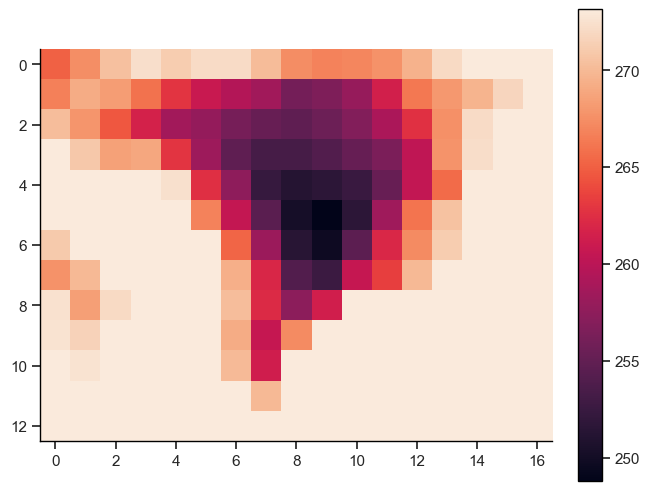

In [7]:
import matplotlib.pyplot as plt

[lat, lon] = [grp["lat"][:], grp["lon"][:]]
tas = grp["tas"][:, (lat >= 59) & (lat <= 83), (lon >= 286) & (lon <= 349)]
mask = tas[-1] < 273.15
x = tas[-1]

x[mask] = x[mask]
x[~mask] = 273.15

plt.imshow(x[::-1])
plt.grid(False)
plt.colorbar();

temps = [240.47 242.   243.91 ... 268.34 265.52 263.22]
yrs = [  0   0   0 ... 294 294 294]
chunked =
	[[240.47 242.   243.91 ... 254.38 248.07 241.32]
	 [238.61 239.11 243.87 ... 252.68 246.61 243.23]
	 [239.68 240.64 243.54 ... 251.35 243.64 242.59]
	 ...
	 [258.91 263.27 261.72 ... 269.57 265.38 262.05]
	 [258.28 257.18 258.25 ... 269.48 267.91 264.15]
	 [258.52 259.41 260.15 ... 268.34 265.52 263.22]]


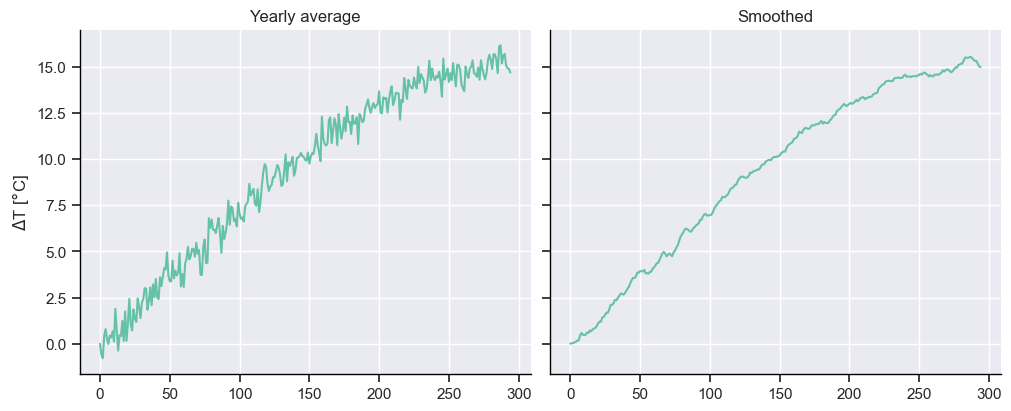

In [8]:
temps = np.mean(np.asarray(tas[:, mask]), axis=-1)
print(f"temps = {temps}")

yrs = np.array(grp.variables["time"][:] // 365).astype(int)
print(f"yrs = {yrs}")

chunked = np.array([temps[yrs == yr] for yr in np.unique(yrs)])
print(f"chunked =\n{"\n\t".join(["", *f"{chunked}".split("\n")])[1:]}")

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))


avgs = np.mean(chunked, axis=-1)
axes[0].plot(avgs - avgs[0])  # Kelvin difference == Celsius difference
axes[0].set_ylabel(r"$\Delta$T [$\degree$C]")
axes[0].set_title("Yearly average")


def smooth(x: np.ndarray, wlen: int) -> np.ndarray:
    w = np.ones(wlen, "d")
    padded = np.pad(x, (wlen // 2, wlen - 1 - wlen // 2), mode="edge")
    return np.convolve(padded, w / w.sum(), mode="valid")


smoothed_temps = smooth(avgs, 10)
axes[1].plot(smoothed_temps - smoothed_temps[0])
axes[1].set_title("Smoothed");

Nice! Now we have to write this out to a file that SICOPOLIS understands. `sico_in/general/grl_warming_scenario_rcp26.asc`. We'll take the temperature from there, too.


In [9]:
dt_2006 = 5.8161056e-01

time = 2006 + np.unique(yrs) - 1990
dtemps = (smoothed_temps - smoothed_temps[0]) + dt_2006
print(len(time), len(dtemps))

295 295


In [10]:
start, end = time[[0, -1]]
step = time[1] - time[0]

contents = f"""#  {start}  {step}  {end}
{"\n".join([f"  {yr}  {t}" for yr, t in zip(time, dtemps)])}

# --------------------------------------------------------------------------------
# Greenland surface temperature anomaly from RCP8.5 scenario for years 2006 - 2300
# Year (relative to 1990 CE) - Delta T [C]
# --------------------------------------------------------------------------------
"""

with open(f"{DATA_DIR}/grl_rcp85.dat", "w") as f:
    f.write(contents)

## Running the model


Now we can actually run the model.


a = annus; years in Latin.


`-a` doesn't take relative paths - so no `-a ./sico_in/...`, but `-a /home/user/sicopolis/sico_in/...`.


`(./sico.sh -f -m repo_grl20_b2_paleo21) >tmp/out_001.dat` (took ~1h12m)
`(./sico.sh -f -m grl20_rcp85 -a /home/jelmar/Github/portfolio/sicopolis/sico_out/repo_grl20_b2_paleo21) >tmp/out_001.dat`



<Note type="info">info</Note>

<Note type="warning">
  warning
</Note>

<Code
  language="fortran"
  oldFilename="sico_specs_repo_grl10_b2_future21_asmb.h"
  filename="sico_specs_grl20_rcp85.h"
  oldValue="file:./data/sico_specs_repo_grl10_b2_future21_asmb.h"
  value="file:./data/sico_specs_grl20_rcp85.h"
/>

## Processing output data


Output files will be in the folder `sico_out/grl20_rcp85` (or whatever name you gave to your specfile). An explanation of what these different files contain can be found [here](https://sicopolis.readthedocs.io/en/develop/getting_started.html#getting-started-output), but the gist of it is that the `.ser` or `_ser.nc` files contain scalar variables (`ser` meaning time series), the `.site` or `_site.nc` also contain (different) scalar variables sampled at particular *sites* (which are predefined and specific to your modeling domain), and the files that end in `0001.nc`, `0002.nc` etc. contain full 2D/3D fields (e.g. ice velocity or thickness). These fields are written out at the times we set on line 1322 of our specfile, so in our case it's once every 50 years.

Your directory should look something like this:

<FileTree
  items={[
    {
      name: "sico_out",
      items: [{
        name: "grl20_rcp85",
        items: [
          "grl20_rcp85.core",
          "out_grl20_rcp85.dat",
          "sico_specs_grl20_rcp85.h",
          "grl20_rcp85.log",
          "host_info.log",
          "grl20_rcp85_core.nc",
          "grl20_rcp85_ser.nc",
          "grl20_rcp850001.nc",
          "grl20_rcp850002.nc",
          "grl20_rcp850003.nc",
          "grl20_rcp850004.nc",
          "grl20_rcp850005.nc",
          "grl20_rcp850006.nc",
          "grl20_rcp850007.nc",
          "grl20_rcp85.ser",
        ]
      }]
    }
  ]}
/>

As a first sanity check, we'll get the surface temperature anomaly from the `grl20_rcp85_ser.nc` file to make sure that it corresponds to the input data we generated.

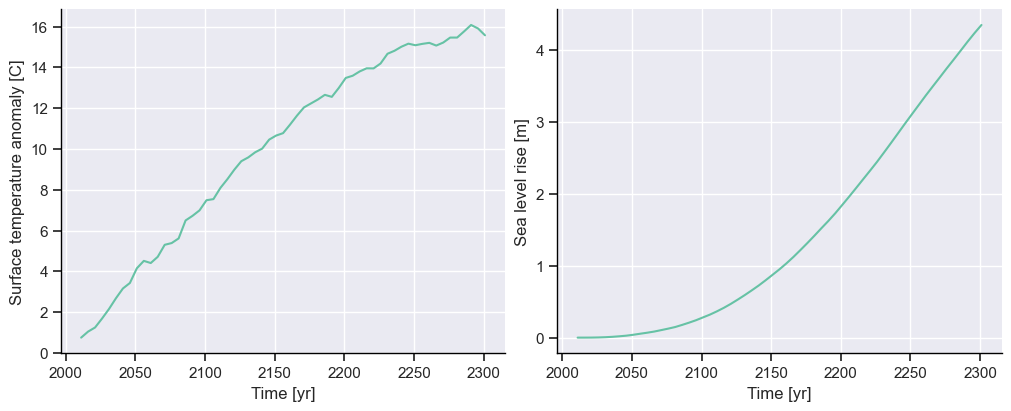

In [11]:
sim_name = "grl20_rcp85"
root = f"{SICOPOLIS_DIR}/sico_out/{sim_name}"
start_year = 1990

ser = Dataset(f"{root}/{sim_name}_ser.nc")

[time, delta_ts, V_sle] = [ser.variables[x][:] for x in ["t", "delta_ts", "V_sle"]]
sle = (V_sle - V_sle[0]) * -1
time += start_year

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(time, delta_ts)
axes[1].plot(time, sle)

axes[0].set_ylabel("Surface temperature anomaly [C]")
axes[1].set_ylabel("Sea level rise [m]")

for ax in axes:
    ax.set_xlabel("Time [yr]")

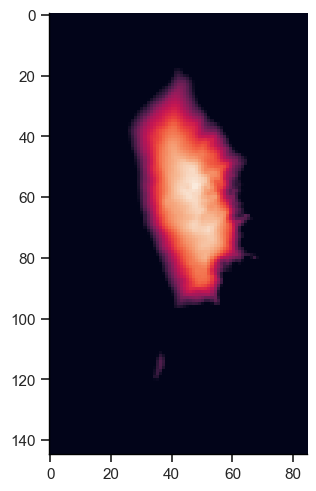

In [12]:
grp = Dataset(f"{root}/{sim_name}0007.nc")
plt.grid(False)
plt.imshow(grp.variables["H"][:][::-1])

In [13]:
[f"{sim_name}{x:04}.nc" for x in range(1, 7 + 1)]

['grl20_rcp850001.nc',
 'grl20_rcp850002.nc',
 'grl20_rcp850003.nc',
 'grl20_rcp850004.nc',
 'grl20_rcp850005.nc',
 'grl20_rcp850006.nc',
 'grl20_rcp850007.nc']